# RadmonForest classifier with validation set

In order to more objectively assess the performance of our classifier, we will split-off a distinct validation set, consisting of 3 representative videos, that contain all behaviours to a useful degree. This also allows us to do a stratified train-test shuffle split, since we use the validation set to assess the actual performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
import scikitplot as skplt
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle

We import a labelled and norlazed frames. However, for now we removed all unlabelled frames, so that we don't end up with a huge imbalance on `not_defined` labels in our data set.

In [ ]:
df = pd.read_hdf("merged_20210405.h5")
df = df[(df['behavior'] != "not_defined")]
dfs

bodyparts      head                               beak                         \
coords            x           y likelihood           x           y likelihood   
34600     -6.256115  133.140698   0.998600   28.458820  157.263363   0.974056   
34601      3.769024  145.079564   0.992194    1.435601  168.635165   0.998704   
34602      0.213448  148.213782   0.997358   -2.950560  176.568780   0.999940   
34603      2.762456  147.657923   0.999761  525.309970  604.796841   0.860005   
34604      2.196279  143.526230   0.997774   34.527160  149.529552   0.999838   
...             ...         ...        ...         ...         ...        ...   
38031      4.897417  177.600705   0.999900   30.771665  203.767842   0.999990   
38032      1.005224  169.487090   0.999758   16.386927  209.473704   0.999982   
38033      1.033190  170.307134   0.999995   11.928434  205.935297   0.999999   
38034     -1.618751  173.363199   0.999999   16.374546  204.249601   1.000000   
38035     -3.469847  172.069851   1.000000   16.637790  200.859973   1.000000   

bodyparts  left_neck                        right_neck  ...       body  \
coords             x           y likelihood          x  ... likelihood   
34600      39.766114   99.337532   1.000000 -39.766114  ...   0.999989   
34601      39.091074  102.566764   0.999997 -39.091074  ...   0.999955   
34602      39.161616  105.930661   0.999996 -39.161616  ...   0.999971   
34603      38.959007  106.304114   0.999999 -38.959007  ...   0.999973   
34604      39.876856  103.607613   1.000000 -39.876856  ...   0.999987   
...              ...         ...        ...        ...  ...        ...   
38031      40.332658  120.383899   0.999997 -40.332658  ...   0.999998   
38032      40.241152  121.762393   0.999998 -40.241152  ...   0.999998   
38033      41.282461  123.487411   1.000000 -41.282461  ...   0.999998   
38034      40.873566  124.888961   0.999999 -40.873566  ...   0.999997   
38035      41.394312  126.094337   0.999999 -41.394312  ...   0.999999   

bodyparts       tail                          middle_neck              \
coords             x           y likelihood             x           y   
34600      16.614607 -106.037636   0.999988 -6.559721e-15   98.676032   
34601      17.690069 -106.504741   0.999975  6.983719e-15  101.558517   
34602      19.303123 -104.565719   0.999963  1.584214e-14  104.192925   
34603      16.542397 -105.026859   0.999965  1.052610e-14  102.874054   
34604      19.000453 -110.547172   0.999992 -1.431422e-14  100.011360   
...              ...         ...        ...           ...         ...   
38031      30.366276 -111.999133   0.999990  2.690406e-14  125.305453   
38032      26.714623 -110.071315   0.999994  2.121088e-14  125.353381   
38033      29.245919 -108.853585   0.999989  3.990525e-15  128.161332   
38034      26.189131 -106.770526   0.999983  4.046852e-14  130.237987   
38035      25.777393 -109.251950   0.999992 -4.745602e-14  129.118538   

bodyparts rotation_angle                                          file_name  \
coords                                                                        
34600        -127.844964  233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJ...   
34601        -127.805934  233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJ...   
34602        -128.614585  233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJ...   
34603        -127.998885  233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJ...   
34604        -128.414942  233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJ...   
...                  ...                                                ...   
38031        -133.738577  892_500ms_gopro_cut_day2DLC_resnet50_goprovrJu...   
38032        -132.919632  892_500ms_gopro_cut_day2DLC_resnet50_goprovrJu...   
38033        -133.700335  892_500ms_gopro_cut_day2DLC_resnet50_goprovrJu...   
38034        -133.262292  892_500ms_gopro_cut_day2DLC_resnet50_goprovrJu...   
38035        -133.115777  892_500ms_gopro_cut_day2DLC_resnet50_goprovrJu...   

bodyp

We have a set of files as distinct sessions results we hand-picked as our test-set, since they are representative of real worlds results and provide a good distribution of different behaviours.

In [ ]:
test_files = [
    "233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "877_100ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    
    "251_100ms_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "418_500ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
]

df_test = df[df['file_name'].isin(test_files)]
df_train_valid = df[~df['file_name'].isin(test_files)]

test_share = len(df_test) / len(df_train_valid)
print(f"Percentage of test frames of overall data set: {test_share}")

Percentage of test frames of overall data set: 0.20230696785413652


The 2D coordinates of all bodyparts are used as features. We specify them manually, since the data frame also contains other data and pre-aggregated data from pre-processing steps. 

Train- and validation-set are taken and split from the remaining data in a random fashion, excluding the frames taken for the test-set.

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

y = df_train_valid['behavior']
x = df_train_valid[features].values

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=13)

x_test = df_test[features].values
y_test = df_test['behavior']

`RandomForestClassifier` is trained in its default configuration. This means e.g. 100 trees in the forest (which is the default) and same class weights for all classes.

In [ ]:
clf = RandomForestClassifier(random_state=0, verbose=1)
clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.6min finished


RandomForestClassifier(random_state=0, verbose=1)

In [ ]:
filename = 'random_forest20210517.sav'
pickle.dump(clf, open(filename, 'wb'))

## Performance on validation set

In [ ]:
predictions = clf.predict(x_valid)
print(classification_report(y_valid, predictions))
print(roc_auc_score(y_valid, clf.predict_proba(x_valid), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


                   precision    recall  f1-score   support

    back_preening       0.98      0.98      0.98      3960
        body_pump       0.92      0.85      0.89      1209
           eating       1.00      1.00      1.00     57342
 feather_clapping       0.93      0.97      0.95      3807
   front_preening       0.98      0.99      0.98      7524
       head_shake       0.99      0.81      0.89      1647
scratch_with_feet       0.99      0.97      0.98       797
         standing       0.99      1.00      0.99     61044
 standing_shaking       0.98      0.99      0.99      1713
       tail_shake       0.98      0.78      0.87      1231
          walking       0.96      0.95      0.95      3708

         accuracy                           0.99    143982
        macro avg       0.97      0.94      0.95    143982
     weighted avg       0.99      0.99      0.99    143982



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


0.9984338658179677


## Performance on test set

In [ ]:
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, clf.predict_proba(x_test), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


                   precision    recall  f1-score   support

    back_preening       0.55      0.77      0.64      2168
        body_pump       0.25      0.35      0.29       355
           eating       0.98      0.93      0.96     69125
 feather_clapping       0.55      0.63      0.59      2263
   front_preening       0.29      0.51      0.37      4770
       head_shake       0.11      0.21      0.14       537
scratch_with_feet       0.23      0.01      0.02      1338
         standing       0.86      0.88      0.87     54374
 standing_shaking       0.03      0.00      0.00       401
       tail_shake       0.62      0.52      0.57       483
          walking       0.53      0.44      0.48      9828

         accuracy                           0.84    145642
        macro avg       0.45      0.48      0.45    145642
     weighted avg       0.85      0.84      0.84    145642



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


0.8605790078606032


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

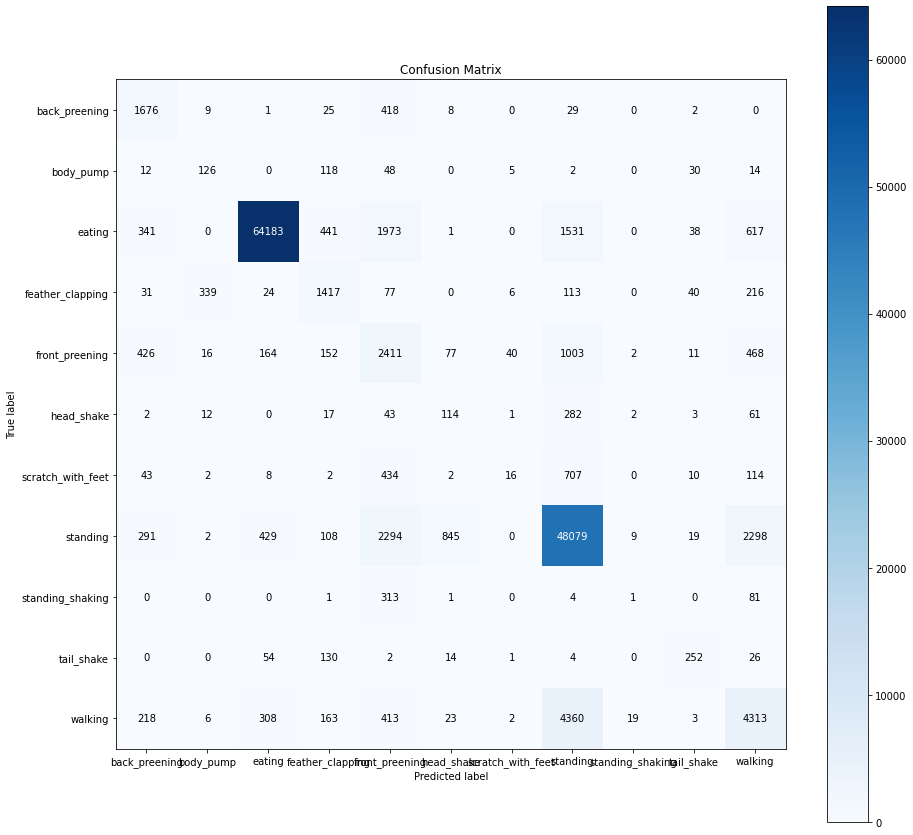

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, figsize=(15, 15))  

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

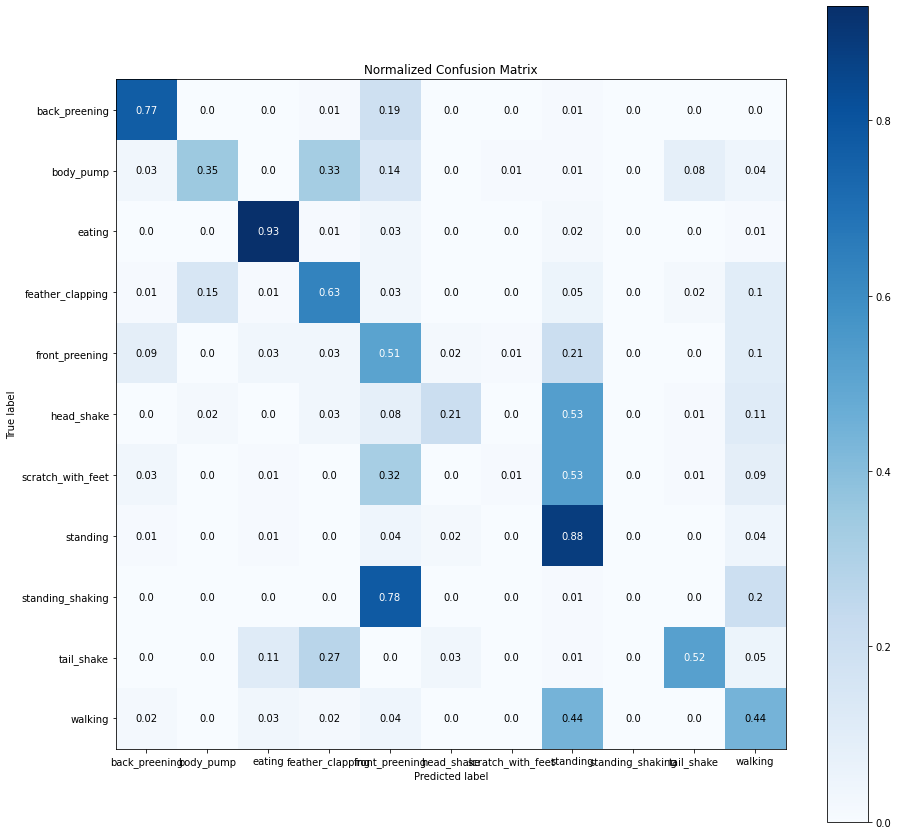

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, figsize=(15, 15), normalize=True)  

# Using class weights
We use again random forest, but this use class weights to combat the unbalanced data.

In [ ]:
clf_cw = RandomForestClassifier(random_state=0, class_weight='balanced')
clf_cw.fit(x_train, y_train)

predictions = clf_cw.predict(x_valid)
print(classification_report(y_valid, predictions))

predictions = clf_cw.predict(x_test)
print(classification_report(y_test, predictions))

                   precision    recall  f1-score   support

    back_preening       0.98      0.98      0.98      3960
        body_pump       0.93      0.84      0.89      1209
           eating       1.00      1.00      1.00     57342
 feather_clapping       0.93      0.98      0.95      3807
   front_preening       0.99      0.98      0.99      7524
       head_shake       1.00      0.80      0.89      1647
scratch_with_feet       1.00      0.97      0.99       797
         standing       0.99      1.00      0.99     61044
 standing_shaking       0.98      0.98      0.98      1713
       tail_shake       0.98      0.78      0.87      1231
          walking       0.97      0.94      0.95      3708

         accuracy                           0.99    143982
        macro avg       0.98      0.93      0.95    143982
     weighted avg       0.99      0.99      0.99    143982

                   precision    recall  f1-score   support

    back_preening       0.63      0.79      0.70    

In [ ]:
print(roc_auc_score(y_test, clf_cw.predict_proba(x_test), multi_class='ovo', average='macro'))

0.863026631069238


# Multi-frame Classification (8 frames)

This will use the same approach and models as the previous runs, but this time, transform multiple frames into feature dimensions (`noFrames * noFeatures = dim(inputVector)`). 

The modal of the multi-frame label vector is used to label the time slice (aka dominant behaviour in time slice).

In [ ]:
from tsai.all import *

In [ ]:
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

x_ts, y_ts = SlidingWindow(8, get_x=features, get_y='behavior', y_func=y_func)(df_train_valid)
x_test_ts, y_test_ts = SlidingWindow(8, get_x=features, get_y='behavior', y_func=y_func)(df_test)

In [ ]:
x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))

In [ ]:
x_test_ts = x_test_ts.reshape((-1, x_test_ts.shape[1] * x_test_ts.shape[2]))

In [ ]:
x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13)

In [ ]:
clf_ts = RandomForestClassifier(random_state=0, verbose=1)
clf_ts.fit(x_ts_train, y_ts_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 78.7min finished


RandomForestClassifier(random_state=0, verbose=1)

In [ ]:
predictions = clf_ts.predict(x_ts_valid)
print(classification_report(y_ts_valid, predictions))

predictions = clf_ts.predict(x_test_ts)
print(classification_report(y_test_ts, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.5s finished


                   precision    recall  f1-score   support

    back_preening       0.96      0.97      0.97      3826
        body_pump       0.91      0.80      0.85      1191
           eating       1.00      1.00      1.00     57408
 feather_clapping       0.88      0.97      0.92      3746
   front_preening       0.98      0.98      0.98      7585
       head_shake       0.95      0.75      0.84      1645
scratch_with_feet       0.99      0.92      0.95       805
         standing       0.99      1.00      0.99     61110
 standing_shaking       0.99      0.99      0.99      1711
       tail_shake       0.96      0.72      0.82      1230
          walking       0.96      0.94      0.95      3723

         accuracy                           0.99    143980
        macro avg       0.96      0.91      0.93    143980
     weighted avg       0.99      0.99      0.99    143980



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


                   precision    recall  f1-score   support

    back_preening       0.61      0.82      0.70      2168
        body_pump       0.27      0.41      0.32       355
           eating       0.98      0.93      0.96     69117
 feather_clapping       0.61      0.65      0.63      2263
   front_preening       0.31      0.55      0.39      4770
       head_shake       0.13      0.16      0.14       537
scratch_with_feet       0.28      0.01      0.02      1338
         standing       0.85      0.88      0.87     54374
 standing_shaking       0.00      0.00      0.00       401
       tail_shake       0.80      0.52      0.63       483
          walking       0.52      0.44      0.47      9828

         accuracy                           0.84    145634
        macro avg       0.49      0.49      0.47    145634
     weighted avg       0.85      0.84      0.84    145634



In [ ]:
pickle.dump(clf_ts, open("random_forest_8", 'wb'))

In [ ]:
print(roc_auc_score(y_test_ts, clf_ts.predict_proba(x_test_ts), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


0.8619411580993238


## 16 Frames

In [ ]:
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

x_ts, y_ts = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df_train_valid)
x_test_ts, y_test_ts = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df_test)
x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))
x_test_ts = x_test_ts.reshape((-1, x_test_ts.shape[1] * x_test_ts.shape[2]))
x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13)

clf_ts = RandomForestClassifier(random_state=0, verbose=1)
clf_ts.fit(x_ts_train, y_ts_train)

predictions = clf_ts.predict(x_ts_valid)
print(classification_report(y_ts_valid, predictions))

predictions = clf_ts.predict(x_test_ts)
print(classification_report(y_test_ts, predictions))

print(roc_auc_score(y_test_ts, clf_ts.predict_proba(x_test_ts), multi_class='ovo', average='macro'))

pickle.dump(clf_ts, open("random_forest_16", 'wb'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 119.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished


                   precision    recall  f1-score   support

    back_preening       0.96      0.97      0.97      3840
        body_pump       0.92      0.80      0.86      1144
           eating       1.00      1.00      1.00     57550
 feather_clapping       0.89      0.97      0.93      3901
   front_preening       0.98      0.98      0.98      7610
       head_shake       0.97      0.77      0.86      1653
scratch_with_feet       0.98      0.94      0.96       794
         standing       0.99      1.00      0.99     60819
 standing_shaking       0.99      0.99      0.99      1676
       tail_shake       0.98      0.74      0.84      1197
          walking       0.97      0.96      0.97      3794

         accuracy                           0.99    143978
        macro avg       0.97      0.92      0.94    143978
     weighted avg       0.99      0.99      0.99    143978



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


                   precision    recall  f1-score   support

    back_preening       0.66      0.83      0.73      2168
        body_pump       0.29      0.43      0.34       355
           eating       0.98      0.93      0.95     69109
 feather_clapping       0.60      0.66      0.63      2263
   front_preening       0.30      0.56      0.39      4770
       head_shake       0.16      0.11      0.13       537
scratch_with_feet       0.00      0.00      0.00      1338
         standing       0.85      0.89      0.87     54374
 standing_shaking       0.00      0.00      0.00       401
       tail_shake       0.80      0.43      0.56       483
          walking       0.56      0.44      0.49      9828

         accuracy                           0.85    145626
        macro avg       0.47      0.48      0.46    145626
     weighted avg       0.85      0.85      0.85    145626



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


0.8540550034252832


In [ ]:
test_files = [
    "233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "877_100ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    
    "251_100ms_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
    "418_500ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
]

for test_file in test_files:
    print("========================================")
    print(test_file)

    df_233 = df[df['file_name'] == test_file]
    x_233, y_233 = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df_233)
    x_233 = x_233.reshape((-1, x_233.shape[1] * x_233.shape[2]))

    predictions = clf_ts.predict(x_233)
    print(classification_report(y_233, predictions))
    print("========================================")

233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with

                   precision    recall  f1-score   support

    back_preening       0.00      0.00      0.00         0
        body_pump       1.00      0.03      0.05       199
           eating       0.98      0.89      0.94     43460
 feather_clapping       0.00      0.00      0.00         0
   front_preening       0.11      0.20      0.14      1221
       head_shake       0.00      0.00      0.00        80
scratch_with_feet       0.00      0.00      0.00         0
         standing       0.80      0.92      0.86     21866
 standing_shaking       0.00      0.00      0.00         0
       tail_shake       0.00      0.00      0.00         0
          walking       0.33      0.22      0.27      3741

         accuracy                           0.85     70567
        macro avg       0.29      0.21      0.20     70567
     weighted avg       0.88      0.85      0.86     70567

877_100ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with

                   precision    recall  f1-score   support

    back_preening       0.59      0.89      0.71       618
        body_pump       0.30      0.95      0.45       156
           eating       0.99      0.99      0.99     25633
 feather_clapping       0.84      0.65      0.73      2172
   front_preening       0.22      0.60      0.32      1564
       head_shake       0.09      0.09      0.09       296
scratch_with_feet       0.00      0.00      0.00      1002
         standing       0.89      0.87      0.88     32508
 standing_shaking       0.00      0.00      0.00         0
       tail_shake       0.43      0.15      0.22       134
          walking       0.69      0.58      0.63      6087

         accuracy                           0.86     70170
        macro avg       0.46      0.52      0.46     70170
     weighted avg       0.87      0.86      0.86     70170

251_100ms_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

                   precision    recall  f1-score   support

    back_preening       0.33      0.42      0.37       112
        body_pump       0.00      0.00      0.00         0
           eating       0.00      0.00      0.00         0
 feather_clapping       0.36      0.96      0.52        91
   front_preening       0.76      0.74      0.75      1753
       head_shake       0.00      0.00      0.00        70
scratch_with_feet       0.00      0.00      0.00       161
         standing       0.00      0.00      0.00         0
 standing_shaking       0.00      0.00      0.00       401
       tail_shake       0.89      0.31      0.46        77
          walking       0.00      0.00      0.00         0

         accuracy                           0.55      2665
        macro avg       0.21      0.22      0.19      2665
     weighted avg       0.55      0.55      0.54      2665

418_500ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5
                   precision    recall  f1-

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kevin\.virtualenvs\winkie-tu0wptfo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn

In [ ]:
from sklearn.metrics import fbeta_score

fbeta_score(y_233, predictions, average='weighted', beta=0.5)

0.7811938956611022